# Section 2a: Comparing model summary statistics

In [3]:
library(tidyverse)
library(GGally)
library(ggpubr)
library(patchwork)
library(ggrepel)
library(data.table)
library(scales)

absmax = function(x) { x[which.max( abs(x) )]}

setwd("~/work/mpra-v2/")

In [5]:
interaction = fread("sumstats/1KG_novaSeq_DESeq2_interaction.txt", header = T)
love = fread("sumstats/1KG_novaSeq_DESeq2_Love_Base.txt", header = T)
contrast = fread("sumstats/1KG_novaSeq_DESeq2_contrast.txt", header = T)

love = subset(love, haploFlag == "Base")
love$pos = as.character(love$pos)

In [ ]:
sabeti = read.table("sabeti/Tewhey-stats.txt", header = T, stringsAsFactors = F)
sabeti.hits = sabeti[which(sabeti$C.Skew.fdr > 1.3 & sabeti$Haplotype == "ref"),]

rsid = read.table("sabeti/Tewhey-rsID-convert.txt", sep = "\t", stringsAsFactors = F)[,-2]
names(rsid) = c("chrom","pos","SNP")

sabeti_rsid = merge(sabeti.hits, rsid, by = "SNP")
sabeti_rsid$pos = as.character(sabeti_rsid$pos)

sabeti_all = merge(sabeti, rsid, by = "SNP")
sabeti_all$pos = as.character(sabeti_all$pos)

In [ ]:
love$inSabeti = ifelse(interaction(love[,c("chrom","pos")]) %in% interaction(sabeti_rsid[c("chrom","pos")]), "yes","no")

love$Pool[which(love$Pool == "Sabeti" & love$inSabeti == "no")] = "1KGTest"
love$Pool[which(love$Pool != "Sabeti" & love$inSabeti == "yes")] = "Sabeti"

love$strand = ifelse(love$strand == "+","pos","neg")

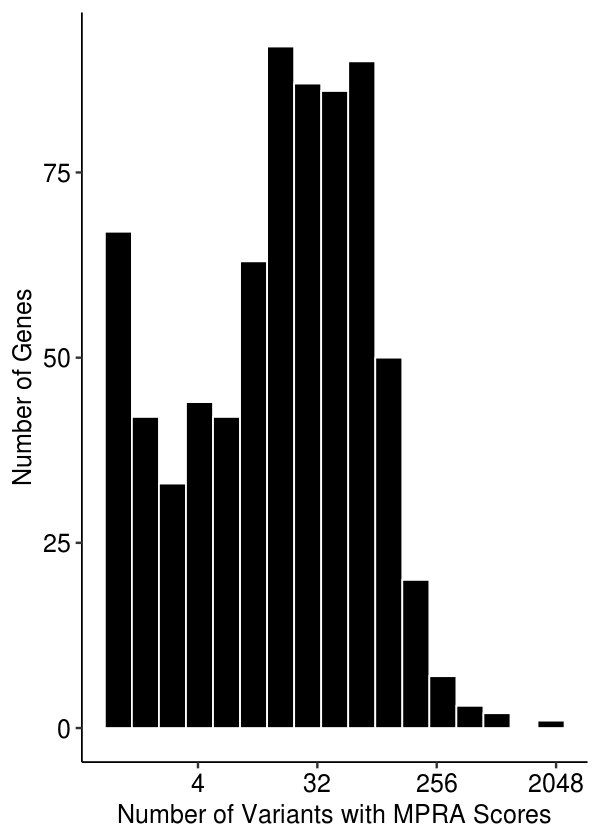

In [193]:
options(repr.plot.width = 5, repr.plot.height= 7)
separate_rows(love, geneID, sep=",") %>% group_by(geneID) %>% summarize("count" = n()) %>% 
    ggplot() + 
        geom_histogram(aes(x = count), bins = 17, color = "white", fill = "black") + 
        theme_pubr(base_size = 15) + 
        scale_x_continuous(trans = "log2") + xlab("Number of Variants with MPRA Scores") + ylab("Number of Genes")

In [6]:
ggd.qqplot_ci = function(xsList, ci=0.95, Main=NULL) {
    cbp1 = c("#E69F00", "#56B4E9", "#009E73","#F0E442", "#0072B2", "#D55E00", "#CC79A7")
    p = ggplot() + 
            geom_abline(intercept=0, slope=1, alpha=0.5) + 
            ggtitle(Main) + 
            theme(plot.title = element_text(hjust = 0.5))
    labels = names(xsList)
    colLabels = c()
    for(i in seq(1,length(xsList),1)){
        xs = xsList[[i]]
        label = labels[i]
        N = length(xs)
        df = data.frame(observed=-log10(sort(xs)), 
                        expected=-log10(1:N / N), 
                        cupper=-log10(qbeta(ci, 1:N, N - 1:N + 1)),
                        clower=-log10(qbeta(1 - ci, 1:N, N - 1:N + 1)))
        p = p + geom_point(data = df, aes(expected, observed),
                           color = cbp1[i],
                           shape=19,
                           size=3)
        colLabels = c(colLabels,label)
        names(colLabels)[i] = cbp1[i]
        }
    p = p + scale_color_manual(values=colLabels, guide="legend")
    return(p)
}

In [7]:
pC = ggd.qqplot_ci(list("tewhey" = subset(love, Pool == "Sabeti" , select = pvalue_expr)$pvalue_expr,
                   "test" = subset(love, Pool == "1KGTest" , select = pvalue_expr)$pvalue_expr,
                   "contrrol" = subset(love, Pool == "1KGControl" , select = pvalue_expr)$pvalue_expr)) +
    theme_pubr(base_size = 15)

In [18]:
pD = ggd.qqplot_ci(list("tewhey" = subset(love, Pool == "Sabeti", select = pvalue_allele)$pvalue_allele,
                   "test" = subset(love, Pool == "1KGTest", select = pvalue_allele)$pvalue_allele,
                   "contrrol" = subset(love, Pool == "1KGControl" , select = pvalue_allele)$pvalue_allele)) + 
    ylim(c(0,35)) +
    theme_pubr(base_size = 15)

In [7]:
hitProps = data.frame("exprProps" = as.numeric(table(love$Pool[which(love$padj_expr < 5e-2)]) / table(love$Pool)),
                      "alleleProps" = as.numeric(table(love$Pool[which(love$padj_allele < 5e-2 )]) / table(love$Pool)))
hitProps$group = c("Non-eQTL","eQTL","Tewhey")
hitProps

exprProps,alleleProps,group
<dbl>,<dbl>,<chr>
0.1050107,0.08049041,Non-eQTL
0.1099728,0.08719014,eQTL
0.4068493,0.19726027,Tewhey


In [195]:
cbp1 = c("#E69F00", "#56B4E9", "#009E73","#F0E442", "#0072B2", "#D55E00", "#CC79A7")
colorList = cbp1[3:1]
names(colorList) = hitProps$Pool

pC1 = ggplot(hitProps) + 
    geom_bar(aes(x = group, y = exprProps, fill = group),  stat = "identity") + 
    geom_text(aes(x = group, y = exprProps - 0.025, label = as.character(round(exprProps,digits = 3))), size = 6.5) + 
    scale_fill_manual(values = colorList) + labs(y = "Proportion of \nVariants with Effect") +
    theme_pubr(legend = "none", base_size = 18,x.text.angle = 45)  + 
    theme(axis.title.x = element_blank())

pD1 = ggplot(hitProps) + 
    geom_bar(aes(x = group, y = alleleProps, fill = group),  stat = "identity") + 
    geom_text(aes(x = group, y = alleleProps - 0.0125, label = as.character(round(alleleProps,digits = 3))), size = 6.5) + 
    scale_fill_manual(values = colorList) + labs(y = "Proportion of \nVariants with Effect") +
    theme_pubr(legend = "none", base_size = 18,x.text.angle = 45)  + 
    theme(axis.title.x = element_blank())

In [197]:
pC + pD

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


png 
  2

png 
  2

png 
  2

In [ ]:
pC1 + pD1

In [9]:
loveSabeti = merge(love, sabeti_rsid, by.x = c("chrom","pos","strand"), by.y = c("chrom","pos","Direction"))
loveSabetiAll = merge(love, sabeti_all, by.x = c("chrom","pos","strand"), by.y = c("chrom","pos","Direction"))

loveSabetiAll$group = "Neither"
loveSabetiAll$group[which(loveSabetiAll$padj_allele < 5e-2 & loveSabetiAll$padj_expr < 5e-2)] = "Abell et al Only"
loveSabetiAll$group[which(loveSabetiAll$C.Skew.fdr > 1.3)] = "Tewhey et al Only"
loveSabetiAll$group[which(loveSabetiAll$padj_allele < 5e-2 & loveSabetiAll$padj_expr < 5e-2 & loveSabetiAll$C.Skew.fdr > 1.3)] = "Both"

`summarise()` ungrouping output (override with `.groups` argument)



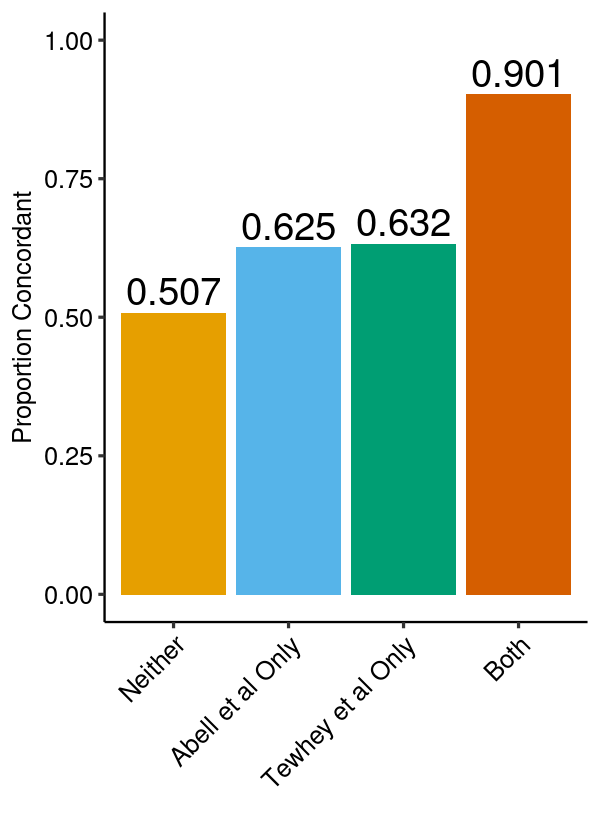

In [10]:
options(repr.plot.width = 5, repr.plot.height = 7)

loveSabetiAll %>% 
    group_by(group) %>% 
    summarize(prop = sum(sign(log2FoldChange_allele) == sign(LogSkew.Comb))/length(LogSkew.Comb)) %>%
    ggplot(aes(x = reorder(group, prop), y = prop, fill = group)) + 
    geom_bar(stat = "identity") + 
    geom_text(aes(y = prop + 0.04, label = round(prop, 3)), size = 8) +
    theme_pubr(base_size = 15, x.text.angle = 45) + 
    theme(legend.position = "none") +
    xlab("") + ylab("Proportion Concordant") + ylim(c(0,1)) +
    scale_fill_manual(values = c("Neither" = "#E69F00",
                                 "Abell et al Only" = "#56B4E9",
                                 "Tewhey et al Only" = "#009E73",
                                 "Both" = "#D55E00"))

Warning message:
“Removed 118 rows containing missing values (geom_point).”


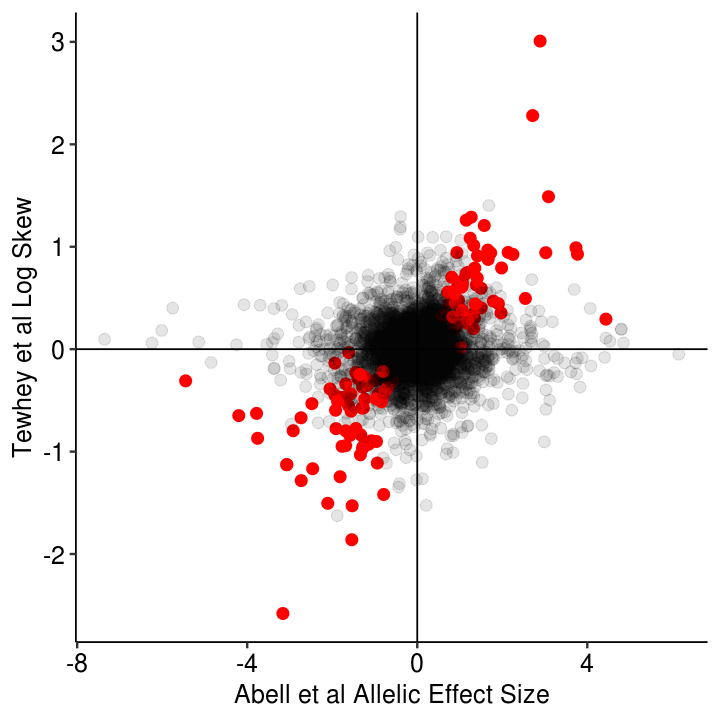

In [69]:
options(repr.plot.width = 6, repr.plot.height = 6)

ggplot(loveSabetiAll, aes(x = log2FoldChange_allele, y = LogSkew.Comb)) + 
    geom_point(aes(alpha = ifelse(padj_allele < 5e-2 &
                                  sign(LogSkew.Comb) == sign(log2FoldChange_allele) &
                                  C.Skew.fdr > 1.3,1,0.2),
                   color = ifelse(padj_allele < 5e-2 &
                                  sign(LogSkew.Comb) == sign(log2FoldChange_allele) &
                                  C.Skew.fdr > 1.3,"red","black")),
               size = 3) + 
    theme_pubr(base_size = 15) + 
    geom_hline(yintercept = 0) + geom_vline(xintercept = 0) + 
    xlab("Abell et al Allelic Effect Size") +
    ylab("Tewhey et al Log Skew") +
    scale_color_manual(values = c("red" = "red", "black" = "black")) +
    theme(legend.position = "none")


  no  yes 
4113  250 

Warning message:
“Removed 2 rows containing missing values (geom_point).”


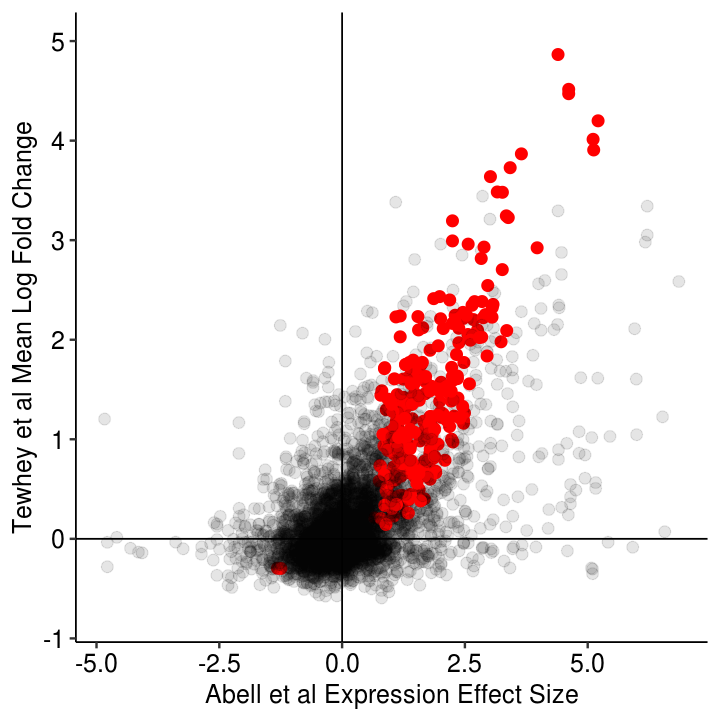

In [92]:
options(repr.plot.width = 6, repr.plot.height = 6)

loveSabetiAll$inList = "no"
loveSabetiAll$inList[which(loveSabetiAll$padj_expr < 5e-2 &
                           loveSabetiAll$C.Skew.fdr > 1.3 &
                           sign(loveSabetiAll$log2FoldChange_expr) == sign(loveSabetiAll$C.A.log2FC + loveSabetiAll$C.B.log2FC)  &
                           abs( ((loveSabetiAll$C.A.log2FC + loveSabetiAll$C.B.log2FC)/2) - loveSabetiAll$log2FoldChange_expr) < 1.32)] = "yes"

ggplot(loveSabetiAll, aes(x = log2FoldChange_expr, y = ((loveSabetiAll$C.A.log2FC + loveSabetiAll$C.B.log2FC)/2) )) + 
    geom_point(aes(alpha = ifelse(inList == "yes", 1,0.2),
                   color = ifelse(inList == "yes", "red","black")),
               size = 3) + 
    theme_pubr(base_size = 15) + 
    geom_hline(yintercept = 0) + geom_vline(xintercept = 0) + 
    ylim(-0.75,5) +
    xlab("Abell et al Expression Effect Size") +
    ylab("Tewhey et al Mean Log Fold Change") +
    scale_color_manual(values = c("red" = "red", "black" = "black")) +
    theme(legend.position = "none")

In [124]:
love$chromPos = paste0(love$chrom, "_", love$pos)
from = 41175000
to = 41425000
knownGenes = UcscTrack(genome = "hg19", chromosome = "chr17", 
                        track = "GENCODE Genes V19", from = from, to = to,
                        trackType = "GeneRegionTrack", 
                        rstarts = "exonStarts", rends = "exonEnds", 
                        gene = "name2", symbol = "name2", 
                        transcript = "name", strand = "strand", 
                        fill = "black", name = "UCSC Genes", col = "black", 
                        fontcolor = "black", cex = 2)

In [125]:
axTrack = GenomeAxisTrack(col = "black", fontcolor = "black", cex = 2)

In [164]:
options(repr.plot.width = 20, repr.plot.height = 5)
coeff = 0.25

pdf("Figure1E.pdf",width = 20, height = 5, useDingbats = F)

ggplot(subset(love, geneID == "ENSG00000012048"),aes(x = pos, label = chromPos)) + 
    geom_point(aes(y = -log(pvalue_expr), color = ifelse(pvalue_expr < 0.01,'red','black')),size = 7) +
    geom_point(aes(y = -log(pvalue_allele)/coeff, color = ifelse(pvalue_allele < 0.01,'dodgerblue','black')),size = 7) +
    theme_classic() +
        theme(text = element_text(size = 16), axis.text.x = element_blank(), axis.title.x = element_blank()) +
    #geom_label_repel(data = subset(love, geneID == "ENSG00000012048" & -log(pvalue_expr) > 100), size = 6, point.padding = 2) +
    scale_x_continuous(limits = c(41175000,41425000), breaks = c(41200000,41300000,41400000)) + scale_color_identity() +
    scale_y_continuous(name = "-log(expression p-value)",sec.axis = sec_axis(~.*coeff, name="-log(allelic p-value)")
  )

plotTracks(list(axTrack, knownGenes), 
           from = from, to = to, showTitle = FALSE,fill="red",fontcolor = "black", showId = TRUE)

dev.off()

Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


png 
  2

In [90]:
options(repr.plot.width = 7, repr.plot.height = 5)

pdf("Figure1E.pdf", width = 4/scaleFactor, height = 4/scaleFactor, useDingbats = FALSE)

ggplot(subset(love, geneID == "ENSG00000012048"),aes(x = pos, y = -log(pvalue_expr), label = chromPos)) + 
    geom_point() +
    theme_classic() +
        theme(text = element_text(size = 16)) +
    geom_text_repel(data = subset(love, geneID == "ENSG00000012048" & -log(pvalue_expr) > 100), size = 6)
dev.off()

pdf("Figure1F.pdf", width = 4/scaleFactor, height = 4/scaleFactor, useDingbats = FALSE)

ggplot(subset(love, geneID == "ENSG00000012048"),aes(x = pos, y = -log(pvalue_allele), label = chromPos)) + 
    geom_point() +
    theme_classic() +
    theme(text = element_text(size = 16)) +
    geom_text_repel(data = subset(love, geneID == "ENSG00000012048" & -log(pvalue_allele) > 20), size = 6)

dev.off()


png 
  2

png 
  2